# TRABALHO 4: Canny e Hough

### Aluno: Kawan Oliveira

## 1. Implemente uma função para detectar bordas de acordo com o algoritmo de Canny. Opcionalmente, você pode utilizar o algoritmo da OpenCV, mas a sua solução irá contar menos pontos

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Função para aplicar o filtro Gaussiano (com menos suavização)
def gaussiano(img, kernel_size=3, sigma=1):
    """ Aplica um filtro Gaussiano com suavização mínima """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), sigma)

# Função para calcular o gradiente usando Sobel
def sobel_gradiente(img):
    """ Calcula os gradientes Gx e Gy usando o filtro Sobel """
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)  # Gradiente na direção x
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)  # Gradiente na direção y
    return grad_x, grad_y

# Função para calcular a magnitude e direção do gradiente
def magnitude_direcao(grad_x, grad_y):
    """ Calcula a magnitude e a direção do gradiente """
    magnitude = np.sqrt(grad_x**2 + grad_y**2)  # Magnitude do gradiente
    direcao = np.arctan2(grad_y, grad_x)  # Direção do gradiente (em radianos)

    # Verificando a faixa da magnitude
    print("Magnitude min: ", np.min(magnitude), "Magnitude max: ", np.max(magnitude))

    return magnitude, direcao

# Função para realizar a supressão não-máxima
def supressao_nao_maxima(magnitude, direcao):
    """ Aplica a supressão não-máxima na magnitude """
    altura, largura = magnitude.shape
    output = np.zeros_like(magnitude, dtype=np.float32)

    # Ajuste da direção do gradiente para um valor de 0, 45, 90 ou 135 graus
    direcao = direcao * 180 / np.pi
    direcao[direcao < 0] += 180  # Direção no intervalo [0, 180]

    for i in range(1, altura - 1):
        for j in range(1, largura - 1):
            angulo = direcao[i, j]

            # Interpolação entre os pixels nas direções
            if (0 <= angulo < 22.5) or (157.5 <= angulo <= 180):
                viz1 = magnitude[i, j + 1]
                viz2 = magnitude[i, j - 1]
            elif (22.5 <= angulo < 67.5):
                viz1 = magnitude[i + 1, j - 1]
                viz2 = magnitude[i - 1, j + 1]
            elif (67.5 <= angulo < 112.5):
                viz1 = magnitude[i + 1, j]
                viz2 = magnitude[i - 1, j]
            else:
                viz1 = magnitude[i - 1, j - 1]
                viz2 = magnitude[i + 1, j + 1]

            # Se a magnitude do pixel central for maior que os dois vizinhos, mantém o valor
            if magnitude[i, j] >= viz1 and magnitude[i, j] >= viz2:
                output[i, j] = magnitude[i, j]
            else:
                output[i, j] = 0

    return output

# Função para aplicar a histerese de limiarização
def histerese_limiar(magnitude, limiar_inferior, limiar_superior):
    """ Aplica a histerese de limiarização para determinar bordas fortes e fracas """
    altura, largura = magnitude.shape
    bordas = np.zeros_like(magnitude, dtype=np.uint8)

    strong = 255
    weak = 75

    # Limiarizando para bordas fortes e fracas
    bordas[magnitude >= limiar_superior] = strong
    bordas[(magnitude >= limiar_inferior) & (magnitude < limiar_superior)] = weak

    # Propagação de bordas fracas conectadas a bordas fortes
    for i in range(1, altura - 1):
        for j in range(1, largura - 1):
            if bordas[i, j] == weak:
                if np.any(bordas[i-1:i+2, j-1:j+2] == strong):
                    bordas[i, j] = strong
                else:
                    bordas[i, j] = 0

    return bordas

# Função principal para detectar bordas de Canny
def detecção_bordas_canny(imagem, kernel_size=3, sigma=1, limiar_inferior=50, limiar_superior=150):
    # Passo 1: Aplicar o filtro Gaussiano (suavização mínima)
    imagem_gaussiana = gaussiano(imagem, kernel_size, sigma)

    # Passo 2: Calcular gradientes usando Sobel
    grad_x, grad_y = sobel_gradiente(imagem_gaussiana)

    # Passo 3: Calcular magnitude e direção do gradiente
    magnitude, direcao = magnitude_direcao(grad_x, grad_y)

    # Passo 4: Aplicar supressão não-máxima
    imagem_supressa = supressao_nao_maxima(magnitude, direcao)

    # Passo 5: Aplicar histerese de limiarização
    bordas = histerese_limiar(imagem_supressa, limiar_inferior, limiar_superior)

    return bordas

# Carregar a imagem em escala de cinza
imagem = cv2.imread('Lenna.png', cv2.IMREAD_GRAYSCALE)

# Ajustar os limiares
limiar_inferior = 50
limiar_superior = 100

# Detectar bordas de Canny
bordas_canny = detecção_bordas_canny(imagem, limiar_inferior=limiar_inferior, limiar_superior=limiar_superior)

# Exibir a imagem original e as bordas detectadas
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(imagem, cmap='gray')
plt.title('Imagem Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(bordas_canny, cmap='gray')
plt.title('Bordas de Canny')
plt.axis('off')

plt.show()


A ideia aqui é implementar a detecção de bordas usando um algoritmo Canny próprio.

O código começa com a função de filtro gaussiano; ela aplica um filtro gaussiano na imagem para suavizá-la levemente. O filtro ajuda a reduzir o ruído e detalhes finos, permitindo que as bordas sejam mais facilmente detectadas. No entanto, o filtro não deve ser muito forte para não apagar bordas importantes (descobri puramente testando).

A função cv2.GaussianBlur aplica o filtro Gaussiano, reduzindo o ruído na imagem de forma controlada.

Após isso, temos a função para calcular gradientes usando Sobel. A detecção de bordas envolve calcular o gradiente da imagem, que indica a intensidade da variação de cor ou brilho de um ponto para o seu vizinho. O operador Sobel é um método comum para calcular os gradientes da imagem em duas direções: horizontal (Gx) e vertical (Gy).

Depois de calcular os gradientes nas direções x e y, a próxima etapa é calcular a magnitude e a direção do gradiente com uma função para calcular magnitude e direção do gradiente, sendo ela a magnitude_direcao. A magnitude representa a intensidade do gradiente, ou seja, o quão forte é a borda em um ponto, e a direção representa a direção da borda, ou seja, o ângulo de inclinação da borda em relação ao eixo horizontal.

Temos a nossa função de supressão não-máxima (NMS), que é uma etapa importante que elimina pixels que não são máximos locais na direção do gradiente. Ela ajuda a afiar as bordas e remover ruídos; e a nossa função de limiarização com histerese

A nossa função principal detecção_bordas_canny organiza todos os passos do algoritmo de Canny:
- Suaviza a imagem com o filtro Gaussiano.
- Calcula os gradientes com Sobel.
- Calcula a magnitude e direção dos gradientes.
- Aplica a supressão não-máxima.
- Realiza a limiarização com histerese para identificar as bordas.

Após as funções serem criadas, carregamos nossa imagem, os limiares, chamamos a função criada de canny, e plotamos o resultado.



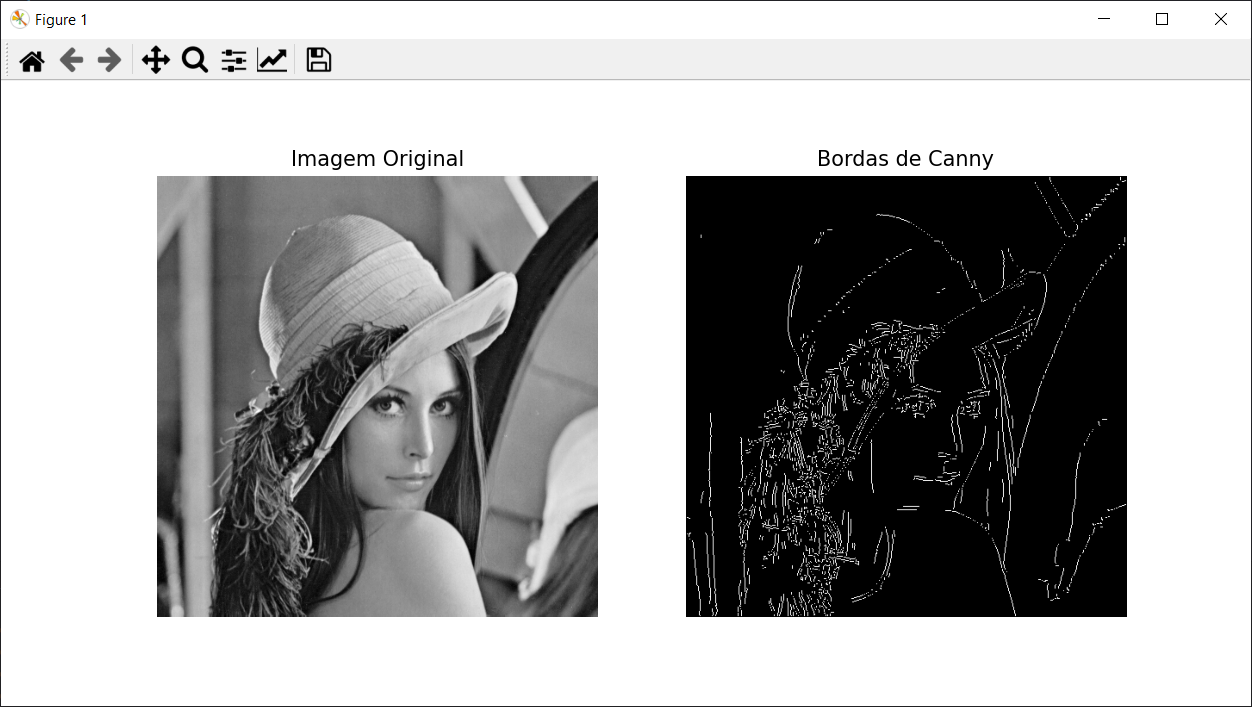

Confesso que esse foi um código que, embora grande, foi mais simples de implementar do que eu imaginava, visto que existia bastante material disponível na internet para se referenciar, e desde os primeiros testes foi um código que já atingiu resultados bem próximos do esperado. Inicialmente, busquei ver como funcionava a função própria da openCV, para ter uma base do que eu precisaria implementar no código; fui juntado algumas funções próprias da openCV para montar um código funcional, e aos poucos fui substituindo por funções próprias minhas implementadas após entender melhor o que cada coisa fazia.

## 2. Implemente uma função para detectar linhas retas em uma imagem de acordo com o algoritmo de Hough. Opcionalmente, você pode utilizar o algoritmo da OpenCV, mas a sua solução irá contar menos pontos

Essa implementação foi uma que particularmente me foi trabalhosa pois demorei um pouco para entender a dinâmica de como o código deveria funcionar, e durante minhas pesquisas, encontrei bastante exemplos "funcionais", porém que ao testar com parâmetros diferentes, ou até apenas com uma imagem diferente, apresentavam resultados nem um pouco satisfatórios. Percebi que filtrar as linhas é um trabalho complexo (bem mais complexo do que eu imaginava), pois os parâmetros que passamos me pareceram ser bastante "sensíveis" para o código entender o que poderia ser considerado uma linha ou não; isso se mostrou bastante problemático para mim ao testar com duas imagens de estrada diferente: uma com faixa contínua e outra com a faixa comum que conhecemos (a faixa tracejada clássica).

In [ ]:
import cv2
import numpy as np

# Função para desenhar as linhas detectadas
def draw_lines(image, lines):
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Ler a imagem
image = cv2.imread('estrada.png')

# Converter para escala de cinza
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Ajustar os parâmetros do Canny para detecção de bordas
# Tentando limiares mais amplos para detectar bordas visíveis
edges = cv2.Canny(gray, 50, 200, apertureSize=3)

# Exibir a imagem de bordas detectadas para verificar
cv2.imshow('Canny Edges', edges)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Parâmetros para a Transformada de Hough
lines = cv2.HoughLinesP(
    edges,                # Imagem com bordas
    1,                    # Resolução em pixels
    np.pi / 180,          # Resolução angular em radianos
    threshold=150,        # Número mínimo de votos para uma linha ser válida
    minLineLength=100,    # Comprimento mínimo para uma linha ser detectada
    maxLineGap=10         # Máximo de espaço entre segmentos para formar uma linha contínua
)

# Verificar se alguma linha foi detectada
if lines is not None:
    # Desenhar as linhas detectadas
    draw_lines(image, lines)
else:
    print("Nenhuma linha detectada.")

# Salvar e exibir a imagem com as linhas detectadas
cv2.imwrite('detectedLines.png', image)
cv2.imshow('Detected Lines', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

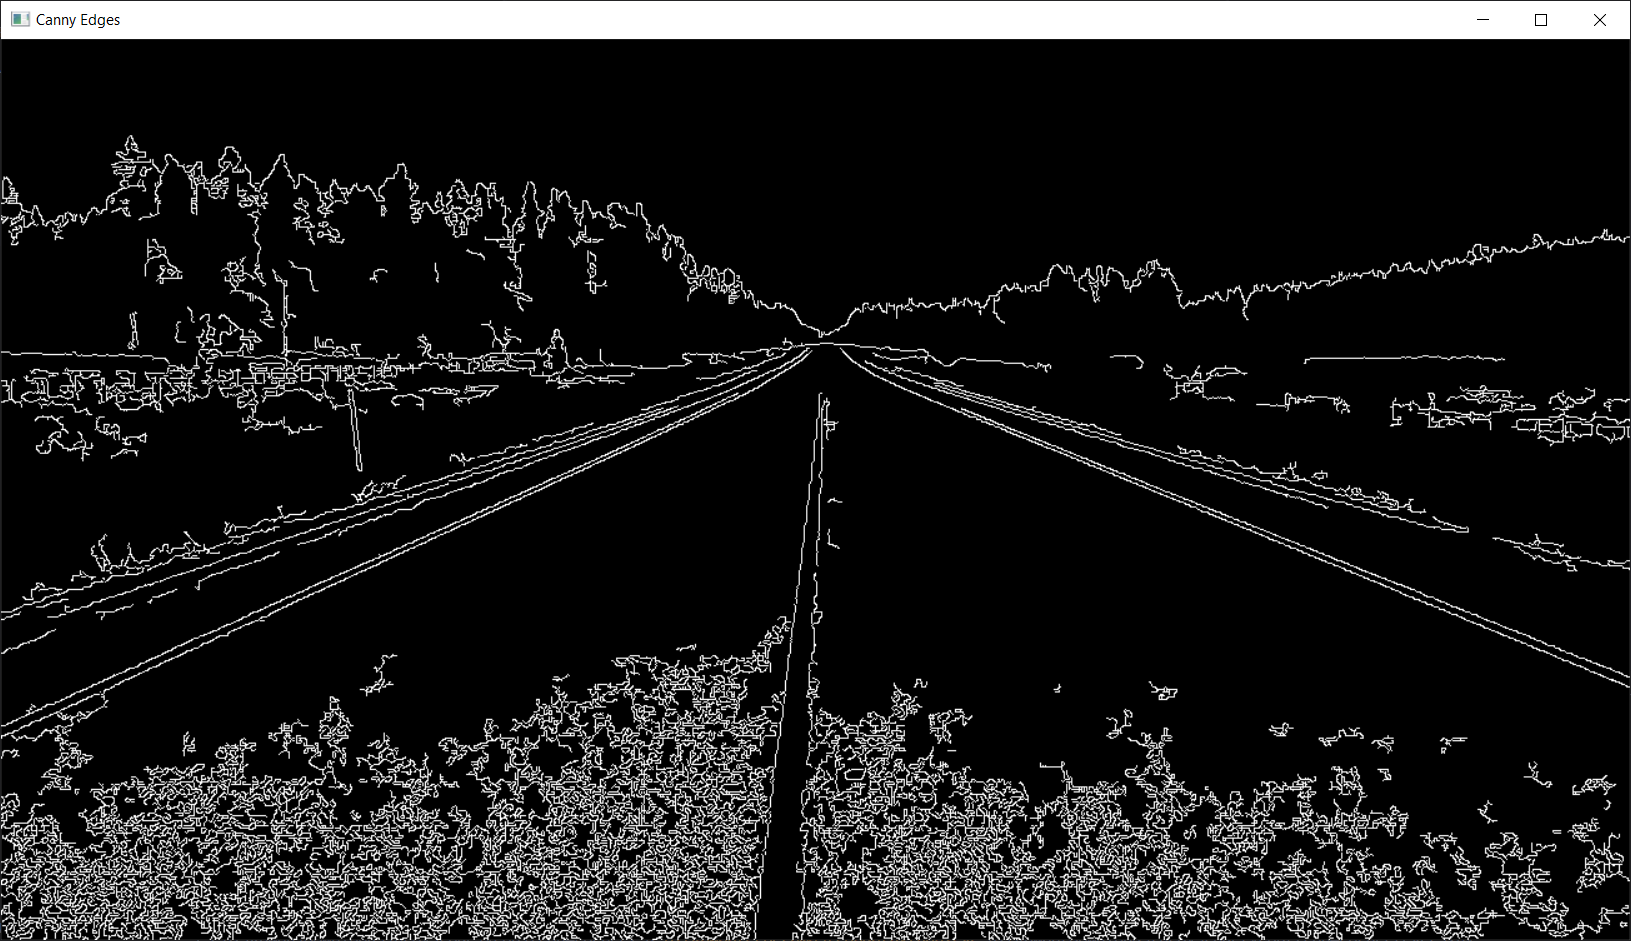

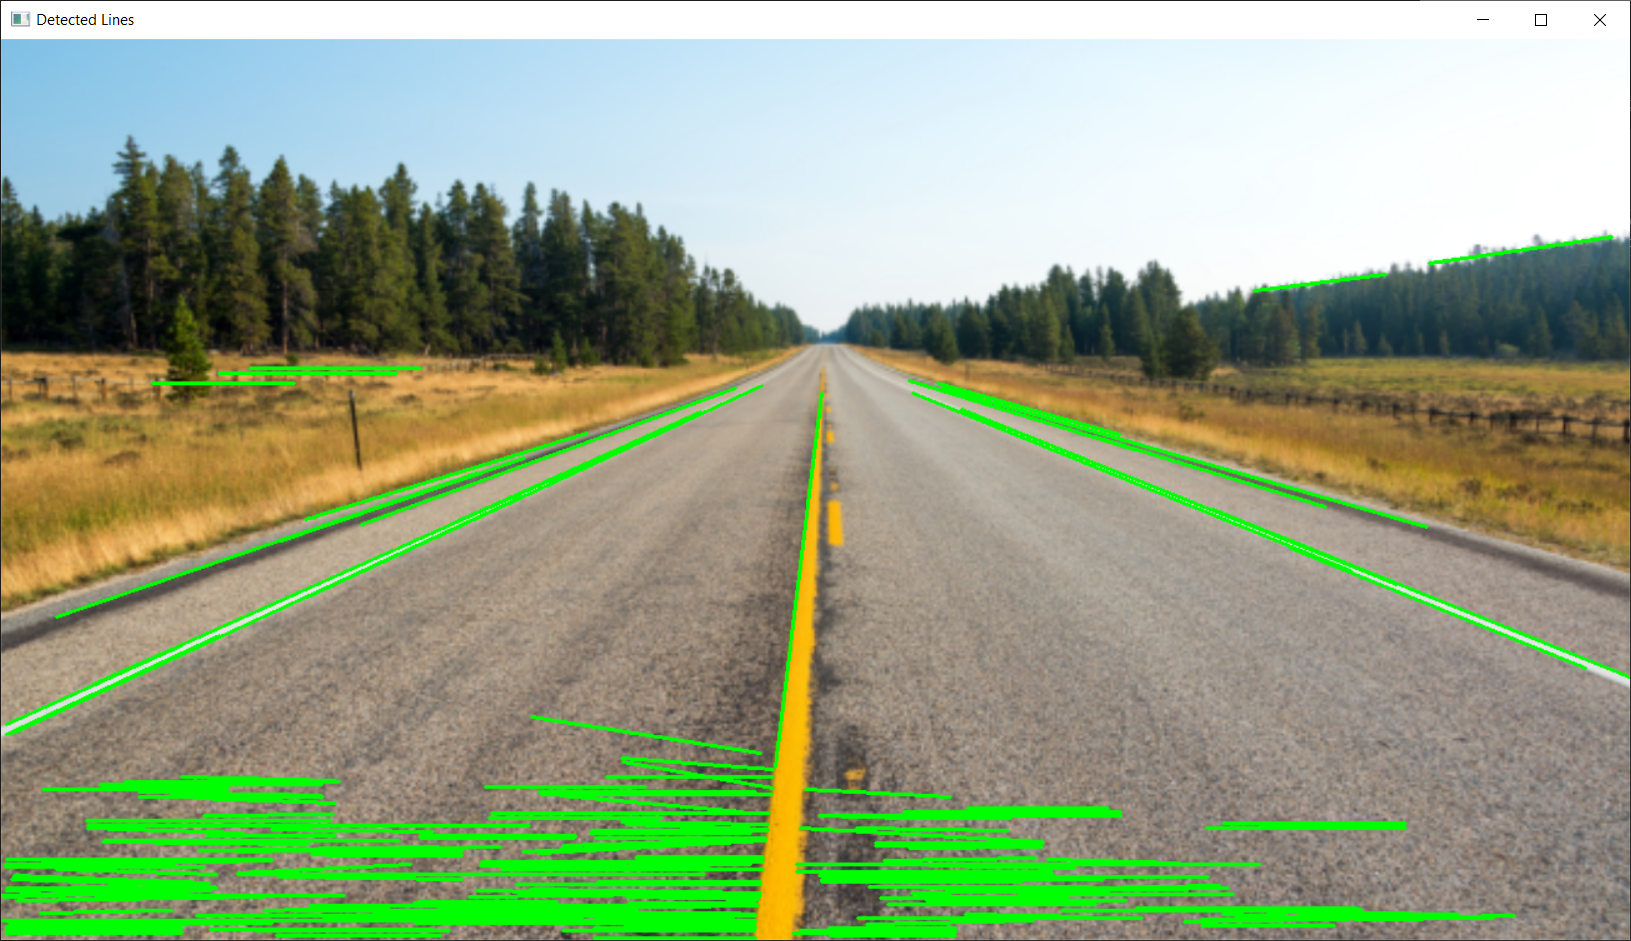

Nessa tentativa de implementação do Hough, percebi que as linhas pareciam bem "ruidosas", apresentando bastante imperfeição na detecção das faixas da estrada. Tentei então, focar num código que detectasse menos linhas, porém que apresentasse o mais próximo possível do que seria a estrada, focando na exibição das linhas da estrada, do acostamento, e algumas poucas na parte de fora da estrada, próximo das árvores.

In [ ]:
import cv2
import numpy as np

# Função para desenhar as linhas detectadas
def draw_lines(image, lines):
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Ler a imagem
image = cv2.imread('estrada.png')

# Converter a imagem para escala de cinza
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Aplicar Canny para detectar as bordas
edges = cv2.Canny(gray, 200, 100, apertureSize=3, L2gradient= True)

# Aplicar HoughLinesP para detectar as linhas
lines = cv2.HoughLinesP(
    edges,              # Imagem com bordas
    1,                  # Resolução em pixels
    np.pi / 180,        # Resolução angular em radianos (1 grau)
    threshold=10,      # Número mínimo de "votos" para uma linha ser detectada (ajustado para maior precisão)
    minLineLength=100,  # Comprimento mínimo da linha (ajustado para capturar faixas longas da estrada)
    maxLineGap=15        # Máximo de espaço para conectar segmentos de linha
    #150,150
)

draw_lines(image, lines)

# Exibir a imagem com as linhas detectadas
cv2.imshow('Detected Lines', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


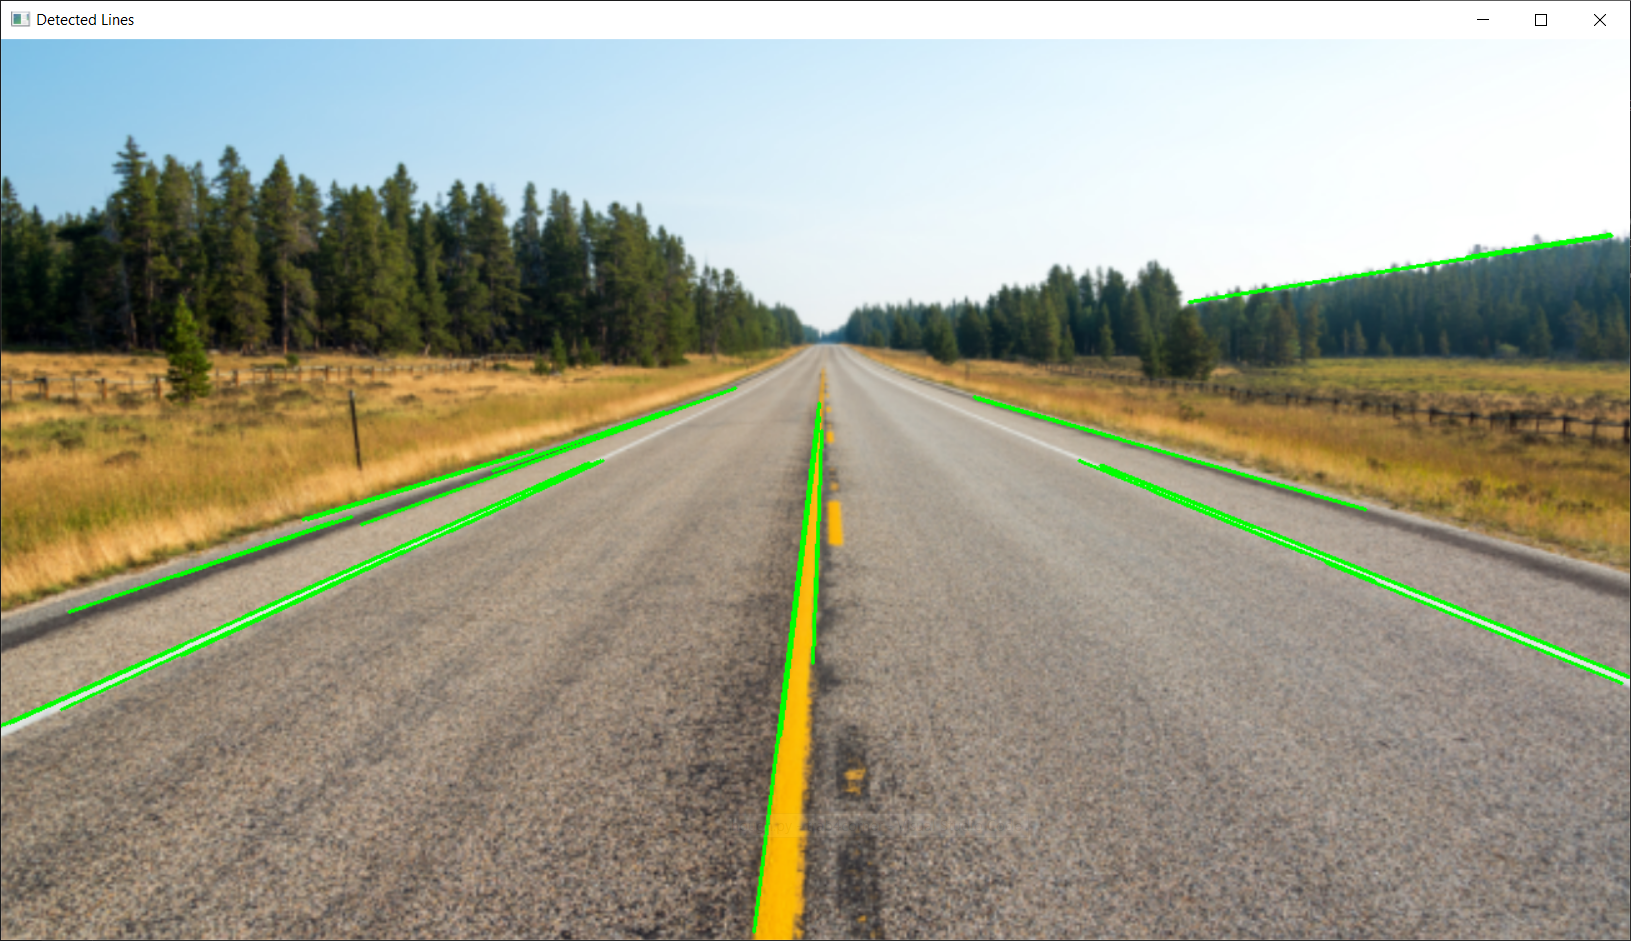

Percebi que com simples ajustes de parâmetro, consegui maior "precisão" na detecção das faixas apenas, pois nesta imagem, temos a presença de uma faixa contínua, o que facilita um pouco a detecção.
Percebi que mudando o apertureSize, eu adquiria uma menor precisão na detecção das linhas, chegando a ter uma imagem quase totalmente verde de tantas linhas ao testar com o apertureSize = 7.
Outra coisa que ao ler a documentação da openCV, e que ao implementar eu senti que melhorou bastante a precisão do meu código, foi o L2gradient, que especifica a equação para encontrar a magnitude do gradiente; se for Verdadeiro, utiliza uma equação mais precisa.

Um detalhe que eu gostaria de destacar nesta implementação é a seguinte: por questões de desempenho durante a execução dos testes, optei por usar a função nativa da openCV para fazer o canny para esse algoritmo de hough, visto que eu senti que o código ficava exponencialmente mais lento de acordo com as implementações que eu ia fazendo e os novos testes; porém, caso fosse fazer com o canny que foi feito no primeiro código, seria apenas designar que 'edges' iria receber a minha implementação do canny, que por sua vez iria chamar as outras funções auxiliares desenvolvidas no algoritmo do canny criado.